In [ ]:
%reset

# gym-DMRO demo on google-colab

# [ * ] Install gym-dmro package

Download zip from github:<br>
https://github.com/Nelson-iitp/gym-DMRO
<br>and upload to session storage

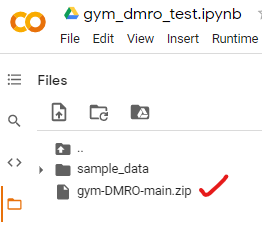

## [1] extract zip

In [1]:
import zipfile
dmro_zip='./gym-DMRO-main.zip'
dmro_dir='./'
with zipfile.ZipFile(dmro_zip, 'r') as zip_ref:
    zip_ref.extractall(dmro_dir)
print('Done!')

Done!


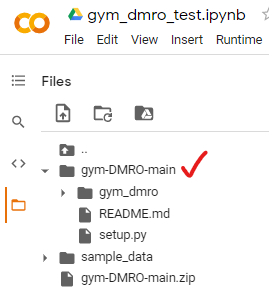

## [2] install with pip

In [2]:
pip install -e ./gym-DMRO-main

Obtaining file:///content/gym-DMRO-main
  Running setup.py develop for gym-dmro


## [3] check the package

In [3]:
pip show gym-dmro

Name: gym-dmro
Version: 0.0.1
Summary: gym environment for task placement in Edge Networks
Home-page: UNKNOWN
Author: Nelson Sharma
Author-email: None
License: UNKNOWN
Location: /content/gym-DMRO-main
Requires: gym
Required-by: 


## [4] * RESTART REQUIRED *

In [ ]:
# restart your kernel --> for colab goto Runtime > Restart runtime

## [5] Import the module

In [1]:
# import should be succesfull without any error
import gym_dmro
from gym_dmro.envs.dmro_infra import INFRA #<----- Infrastructure Class (describes Edge Network)
from gym_dmro.envs.dmro_infra import ENV   #<----- Environment Class (describes State Vectors, Utility & Reward functions)
from gym_dmro.envs.dmro_hplog import HPLOG #<----- HTML PAGE LOGGER Class (for generating HTML Reports)
from gym_dmro.envs.dmro_dqn import AGENT_DQN #<----- Deep Q-Network based AGENT

print('Done!')


[DMRO-GYM]::Called register_init

[INFO]: Registered Environment: dmro-v1
[INFO]: Registered Environment: dmro-v2
[INFO]: Registered Environment: dmro-v3
[INFO]: Registered Environment: dmro-v4

[DMRO-GYM]::Done!

[DMRO-GYM]::Called import_init


[DMRO-GYM]::Done!

Done!


# [ + ] Build and Test a DMRO Environment

## [0] Global Section

In [2]:
import gym
import math
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import floyd_warshall
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.models import clone_model
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# function for finding shortest path and effective Data Rate (bandwidth) b/w edge servers
def effective_bandwidth(M):
    graph = np.copy(M)  #[1:,1:]
    lm = len(graph)
    for i in range(lm):
        graph[i,i]=0
    for i in range(lm):
        for j in range(i+1, lm):
            if graph[i,j]!=0:
                graph[i,j] = 1/graph[i,j]
            graph[j,i] = graph[i,j]
    dist_matrix, predecessors = floyd_warshall(csgraph=graph, 
                                               directed=False, 
                                               return_predecessors=True)
    
    return 1/dist_matrix
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
print('Done!')

Done!


## [1] Create underlying Edge Network

Initialized New Infra ~ E / C / T : 8 / 3 / 4
Initialized New Env: DMRO
Initialized New Env: DMRO


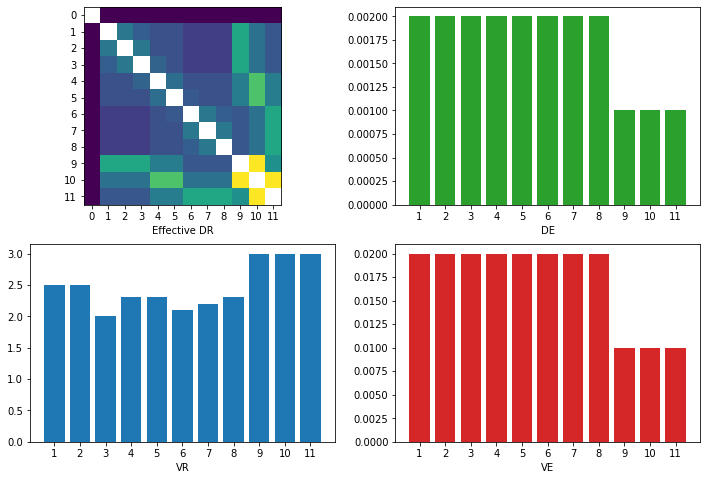

In [3]:
#------------------------------------------------------------------------------
# 1. declare edge network constants
#------------------------------------------------------------------------------
nos_edge = 8
nos_cloud = 3
nos_tasks = 4

#------------------------------------------------------------------------------
# 2. initialize the edge network
#------------------------------------------------------------------------------
Uinfra = INFRA(nos_edge, nos_cloud, nos_tasks)
Uinfra._1_init_const()
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
# 2.1. Set values for infra.DR, infra.DE, infra.VR, infra.VE (device constants)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
DR=	[
	#	iot			e1			e2			e3			e4			e5			e6			e7			e8			c9			c10			c11			#
	[	math.inf,	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			0, 			], # iot
	[	0,			math.inf,	100,		0,			0,			0,			0,			0,			0,			150,		0,			0,			], # e1
	[	0,			0,			math.inf,	100,		0,			0,			0,			0,			0,			150,		0,			0, 			], # e2
	[	0,			0,			0,			math.inf,	80,			0,			0,			0,			0,			150,		0,			0, 			], # e3
	[	0,			0,			0,			0,			math.inf,	0,			0,			0,			0,			0,			180,		0, 			], # e4
	[	0,			0,			0,			0,			0,			math.inf,	70,			0,			0,			0,			180,		0, 			], # e5
	[	0,			0,			0,			0,			0,			0,			math.inf,	100,		0,			0,			0,			150,		], # e6
	[	0,			0,			0,			0,			0,			0,			0,			math.inf,	100,		0,			0,			150,		], # e7
	[	0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	0,			0,			150,		], # e8
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	250,		0, 			], # c9
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	250,		], # c10
	[	0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			0,			math.inf,	], # c11
	]
DE = [	math.inf, 	0.002, 		0.002, 		0.002,		0.002,		0.002,		0.002,		0.002,		0.002,		0.001,		0.001,		0.001		]
VE = [	math.inf,	0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.02,		0.01,		0.01,		0.01		]
VR = [	math.inf,	2.50,		2.50,		2.00,		2.30,		2.30,		2.10,		2.20,		2.30,		3.00,		3.00,		3.00		]
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
DE, VR, VE = np.array(DE), np.array(VR), np.array(VE)
DR = effective_bandwidth(np.array(DR))
#print('Effective Bandwidth b/w edge servers:')
#print(DR)

# NOTE !~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# calculating effectve bandwith using floyd-warshal algorithm
# ---> transmission delay and energy consumption is calculated over the two end devices
#      which means energy consumption in handling (transmitting/routing) data 
#      between intermidiate devices in the route is ignored in utility calculation
# /NOTE !~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Uinfra._2_dev_const(DR,DE,VR,VE)
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
# 2.2. Set the IoT and workflow constants
#------------------------------------------------------------------------------
Uinfra._3_iot_limit((30, 50), (0.005, 0.010), (1.0, 1.5), (0.06, 0.10))
Uinfra._4_wf_limits((50, 100), (10,50), (10, 100))

#------------------------------------------------------------------------------
# 3. Create an environment with underlying Infrastructure that will hold the state vector
#------------------------------------------------------------------------------
Uenv = ENV(Uinfra, 
           np.array([1,1,1]),  # delay weights
           np.array([1,1,1]),  # energy weights
           init_Si=True, random_Si=True)

Tenv = Uenv.getClone()
# *** Infrastructure and Base Environment are ready ***
#------------------------------------------------------------------------------

tik = np.arange(0,Uinfra.A)
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].set_xticks(tik)
ax[0,0].set_yticks(tik)
ax[0,0].set_xlabel('Effective DR')
ax[0,0].imshow(DR)

ax[0,1].set_xticks(tik)
ax[0,1].set_xlabel('DE')
ax[0,1].bar(tik, DE, color='tab:green')

ax[1,0].set_xticks(tik)
ax[1,0].set_xlabel('VR',)
ax[1,0].bar(tik, VR, color='tab:blue')

ax[1,1].set_xticks(tik)
ax[1,1].set_xlabel('VE')
ax[1,1].bar(tik, VE, color='tab:red')

plt.show()
#------------------------------------------------------------------------------

# [ + ] Simulate the gym-dmro environment

## [0] Create new environment

In [ ]:
#%%
#------------------------------------------------------------------------------
# 4. Create the gym-dmro environment
#    ----> there are 4 different environments for 4 different reward functions
#------------------------------------------------------------------------------

#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env1 = gym.make('gym_dmro:dmro-v1')
env1._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env2 = gym.make('gym_dmro:dmro-v2')
env2._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env3 = gym.make('gym_dmro:dmro-v3')
env3._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
env4 = gym.make('gym_dmro:dmro-v4')
env4._init_(Uenv)
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#------------------------------------------------------------------------------
print('Done!')
#------------------------------------------------------------------------------

## [1] Select Environment and Render mode

In [ ]:
# select environment 
env = env3

# select a render mode
# 0=text  1=graphical(full state)  2=graphical(placement only)
rmode = 1

# simulation parameters
nos_episodes = 2
nos_timesteps = env.env.T


## [2] Start Simulation

In [ ]:
print('[Start of Simulation]\n')
# simulation over episodes
for i_episode in range(nos_episodes):
    print('\nEPISODE:',i_episode+1,'/', nos_episodes)
    
    # randomize initial state on each episode
    observation = env.reset(randomize=True)
    
    # render Initial State
    env.render(mode=rmode)
    do_break=False
    
    # start stepping through environment
    for t in range(nos_timesteps):
        print('\nTimeStep:', t+1,'/',nos_timesteps)    
        
        #current state vector
        #print('Current State Vector:', observation)
        
        # take an action--------------------------------------
        
        # option 1 - random sample from action space
        #action = env.action_space.sample()
        
        # option 2 - ask user to input action
        print('\n User Input ---> Take an Action b/w [ 0 ,', env.env.A-1,']')
        action = int(input())
        # break if user wants to
        if action>env.env.A-1:
            print('\n!! BREAK !!\n')
            do_break=True
            break
        
        # ----------------------------------------------------
        print('\tAction Taken:   \t',action)
        
        # call step() to go to next state and recieve reward
        observation, reward, done, info = env.step(action)
        #observation, reward, done, info = env.step(action, [0,1,2,3])
        
        print('\tReward Recieved:\t', reward)
        print('\tIn Final State?:\t',done)
        
        #next state vector
        #print('Next State Vector:', observation)
        
        # render after taking action
        env.render(mode=rmode)
        
        # break on end of timesteps
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    
    # break if user wants to
    if do_break:
        print('\n!! HALT !!\n')
        break
        
env.close()
print('\n[End of Simulation]')

# [ + ] Deep Q-Network Agent

## [0] Create environment

In [4]:
#%%~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
genv = gym.make('gym_dmro:dmro-v3')
genv._init_(Uenv)
genv_test = gym.make('gym_dmro:dmro-v3')
genv_test._init_(Tenv)
#------------------------------------------------------------------------------
print('Done!')
#------------------------------------------------------------------------------

Initialized Empty DMRO Env_v3, call _init_(arg_env) to continue
Initialized Empty DMRO Env_v3, call _init_(arg_env) to continue
Done!


## [1] Training Parameters

In [5]:
# select environment and render mode
#------------------------------------------
# DQN Training Parameters
#------------------------------------------
arg_N = genv.env.T*20 # replay mem size
arg_M = 300         # episodes (set of simulations)
arg_T = genv.env.T  # number of moves per episode - before resetting the world - DONT CHANGE
arg_lr = 0.001      # learning rate
arg_dis = 0.99      # discount factor

# prob of greedy action
arg_epsilon = [0.05, 0.001,  0.05,  0.85,  0,                             0.0005] 
#             [e,    decay,  min,   max,  decay_type(0=add,1=multiply)]
arg_mb = genv.env.T*10       # mini batch size for training

arg_tf = genv.env.T*2        # train every this many moves in the environment
arg_uf = 2                 # update frequence, after no of training
#------------------------------------------
print('Replay Mem size:\t',arg_N)
print('Total no of Episodes:\t',arg_M)
print('Moves per Episode:\t',arg_T)
print('Mini batch size:\t',arg_mb)
print('Training Frequency:\t',arg_tf)
print('Update Frequency:\t',arg_uf)
print('Learn_Rate, Discount:\t',arg_lr,',',arg_dis)
print('Epsilon:\t',arg_epsilon)

#===========================================================================================================
# DQN Structure
#===========================================================================================================
def get_DQN(state_dim, action_dim, lr, print_summary): # len(w.getState())
    in_ = Input( shape=(state_dim,), name = "input" )
    den_1 = Dense(256, activation='relu', name = "den_1")(in_)
    den_2 = Dense(128, activation='relu', name = "den_2")(den_1)
    den_3 = Dense(64, activation='relu', name = "den_3")(den_2)
    out_ = Dense(action_dim, activation='linear', name = "output")(den_3)
    model=Model(inputs=in_, outputs=out_, name='DQN')
    #-------------------------------------
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model

dqn_agent=AGENT_DQN("Xero", 
                    get_DQN(len(genv.S), genv.env.A,arg_lr,False),
                    genv, genv_test)


Replay Mem size:	 80
Total no of Episodes:	 300
Moves per Episode:	 4
Mini batch size:	 40
Training Frequency:	 8
Update Frequency:	 2
Learn_Rate, Discount:	 0.001 , 0.99
Epsilon:	 [0.05, 0.001, 0.05, 0.85, 0, 0.0005]
Initialized DQN Agent: Xero
Model: "DQN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
den_1 (Dense)                (None, 256)               5376      
_________________________________________________________________
den_2 (Dense)                (None, 128)               32896     
_________________________________________________________________
den_3 (Dense)                (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 12)                780       
Total params: 4

## [2] DQN Training

In [6]:
rmode = 0
#*********************************************************
timestamp_start = datetime.datetime.now()
#*********************************************************
print('Starting DQN Iterations...\n')
qq,tt,tup,dpies,drews,deps,dmaxi,dutil = \
dqn_agent.get_QVdeep_QT(arg_N, arg_M, arg_T, arg_lr, 
                       arg_dis, arg_epsilon, arg_mb, arg_uf, arg_tf,
                       verbose=1, show_agent=False,random_init_state=False,clear_mem=True,render_mode=1)
print('\n... Done!, Total Updates made to TNET:'+str(tup))
#*********************************************************
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))
#*********************************************************


Starting DQN Iterations...


 Starting iterations...
Reset to Random Initial State

 ===> Episode: [1] :: Base Epsilon: 0.05
Reset to Random Initial State

 ===> Episode: [2] :: Base Epsilon: 0.0505
Reset to Random Initial State

 ===> Episode: [3] :: Base Epsilon: 0.051000000000000004
Reset to Random Initial State

 ===> Episode: [4] :: Base Epsilon: 0.051500000000000004
Reset to Random Initial State

 ===> Episode: [5] :: Base Epsilon: 0.052000000000000005
Reset to Random Initial State

 ===> Episode: [6] :: Base Epsilon: 0.052500000000000005
Reset to Random Initial State

 ===> Episode: [7] :: Base Epsilon: 0.053000000000000005
Reset to Random Initial State

 ===> Episode: [8] :: Base Epsilon: 0.053500000000000006
Reset to Random Initial State

 ===> Episode: [9] :: Base Epsilon: 0.054000000000000006
Reset to Random Initial State

 ===> Episode: [10] :: Base Epsilon: 0.05450000000000001
Reset to Random Initial State

 ===> Episode: [11] :: Base Epsilon: 0.055
Reset to Random Initial

## [3] DQN Testing


Simulate Q-Values for current policy
----------------------------------------------------

+++ STATE RENDER BEGIN [ DMRO ]+++++++++++++++++++++++++++++++++++++++++
Current State:	 1
 >> 1 	92.0 	0.0 	60.0 	11.0 	-1.0
    2 	11.0 	-1.0 	16.0 	49.0 	-1.0
    3 	49.0 	-1.0 	72.0 	44.0 	-1.0
    4 	44.0 	-1.0 	22.0 	38.0 	-1.0
IoT Constants: >::3.0::38.554576::0.00618::1.473026::0.097989::<
+++ STATE RENDER END [ DMRO ]+++++++++++++++++++++++++++++++++++++++++++
0 	 Action: 10 Reward: -24.070561105621632 [ False ] Sum Reward: -24.070561105621632

+++ STATE RENDER BEGIN [ DMRO ]+++++++++++++++++++++++++++++++++++++++++
Current State:	 2
    1 	92.0 	0.0 	60.0 	11.0 	10.0
 >> 2 	11.0 	10.0 	16.0 	49.0 	-1.0
    3 	49.0 	-1.0 	72.0 	44.0 	-1.0
    4 	44.0 	-1.0 	22.0 	38.0 	-1.0
IoT Constants: >::3.0::38.554576::0.00618::1.473026::0.097989::<
+++ STATE RENDER END [ DMRO ]+++++++++++++++++++++++++++++++++++++++++++
1 	 Action: 11 Reward: -5.597333333333333 [ False ] Sum Reward: -29.6678944389

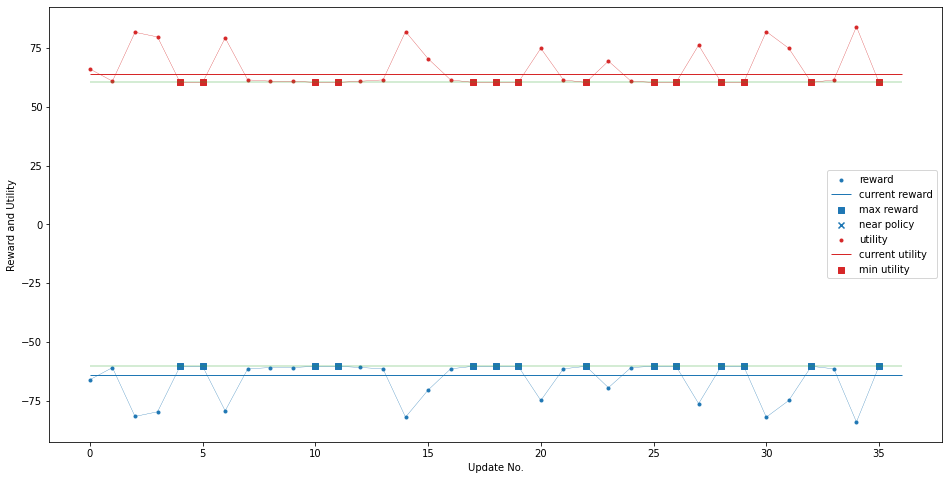

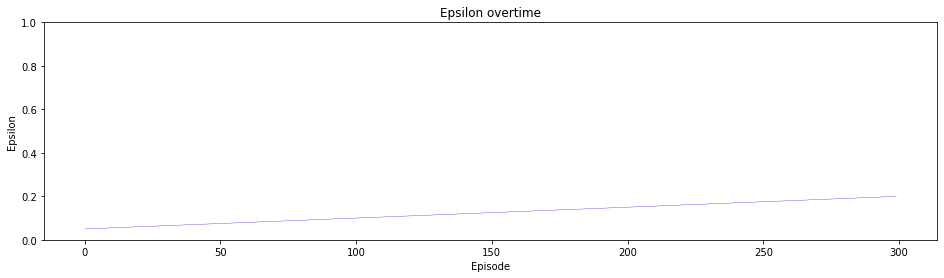

In [8]:
drews=np.array(drews)
max_rews = np.max(drews)
max_loc = np.where(drews==max_rews)[0]
dutil = np.array(dutil)
min_util = np.min(dutil)
min_loc = np.where(dutil==min_util)[0]
#------------------------------------------------

print('\nSimulate Q-Values for current policy')
print('----------------------------------------------------')
#------------------------------------------------
dqn_agent.tenv.reset(randomize=True)
tpie, trew,ttrew,tutil = dqn_agent.Test_QVdeep(verbose=True, render_mode=0)
print('[CURRENT Q-NET POLICY]')
print('Action Sequence:', tpie)
print('Reward Sequence:', trew, '\nTotal Reward:', ttrew, '\nUtility:',tutil)
#wt.printState()

#------------------------------------------------
#print('----------------------------------------------------')
#tpie, trew,ttrew,tutil = Test_QVdeep(tt, wt, wt.nT+1,verbose=False, show_agent=False)
#print('[CURRENT T-NET POLICY]')
#print('Action Sequence:', tpie)
#print('Reward Sequence:', trew, '\nTotal Reward:', ttrew, '\nUtility:',tutil)
#wt.printState()
#wt._reset_world()

#print(this_locs)
#------------------------------------------------
print('----------------------------------------------------')
print('[DURING LEARNING]')
print('\nTotal Updates made to T-NET:', len(drews))
print('\n[MAX_REWARD]:',max_rews)
for i in range(len(max_loc)):
    print('Update#:',max_loc[i]+1, 'Policy:',dpies[max_loc[i]],'\t Rew:',drews[max_loc[i]],'\tUtil:',dutil[min_loc[i]])
    
print('\n[MIN_UTILITY]:',min_util)
for i in range(len(min_loc)):
    print('Update#:',min_loc[i]+1, 'Policy:',dpies[min_loc[i]],'\t Rew:',drews[min_loc[i]],'\tUtil:',dutil[min_loc[i]])
print('----------------------------------------------------')
delta_ignore = 0.5
this_locs = np.where(abs(drews-ttrew)<delta_ignore)[0]
print('\n[CLOSE TO CURRENT Q_NET POLICIES] Total Policies:', len(this_locs),' delta:',delta_ignore)
#for i in range(len(this_locs)):
    #print('Update#:',this_locs[i]+1, 'Policy:',dpies[this_locs[i]],' Reward:',drews[this_locs[i]], ' Util:',dutil[this_locs[i]])
print('----------------------------------------------------')

plt.figure(figsize=(16,8))
plt.xlabel('Update No.')
plt.ylabel('Reward and Utility')

plt.scatter(np.arange(0,len(drews),1),drews,marker='.',color='tab:blue',label='reward') # label='reward_obtained'
plt.plot(drews,linewidth=0.3,color='tab:blue')
plt.hlines(ttrew,0,len(drews),color='tab:blue', linewidth=1, label='current reward')
plt.hlines(max_rews,0,len(drews),color='tab:green', linewidth=0.4)
plt.scatter(max_loc, np.zeros(len(max_loc))+max_rews,marker='s', color='tab:blue', label='max reward')
plt.scatter(this_locs, drews[this_locs] ,marker='x', color='tab:blue', label='near policy')
#-------------------------++++++++++++++++++++++++
plt.scatter(np.arange(0,len(dutil),1),dutil,marker='.',color='tab:red',label='utility')
plt.hlines(tutil,0,len(drews),color='tab:red', linewidth=1, label='current utility')
plt.plot(dutil,linewidth=0.3,color='tab:red')
plt.scatter(min_loc, np.zeros(len(min_loc))+min_util,marker='s', color='tab:red', label='min utility')
plt.hlines(min_util,0,len(drews),color='tab:green', linewidth=0.4)

plt.legend()
plt.show()

#------------------------------------------------
plt.figure(figsize=(16,4))
plt.title('Epsilon overtime')
plt.ylim(0,1)
plt.plot(deps,linewidth=0.3,color='blue')
plt.plot(dmaxi,linewidth=0.3,color='red')
plt.ylabel('Epsilon')
plt.xlabel('Episode')

plt.show()


# Done!